# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl


# Recurrent Network with Excitatory and Inhibitory Neurons

Here we demonstrate how to construct and run a network simulation.

In [7]:
%%bash

nrnivmodl

Creating x86_64 directory for .o files.

/root/Documents/tutorial_6
adexp.mod ccstdpsyn.mod netstim2.mod
adexp.mod ccstdpsyn.mod netstim2.mod
"/usr/local/nrn/x86_64/bin/nocmodl" adexp
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o adexp.lo adexp.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c adexp.c  -fPIC -DPIC -o .libs/adexp.o
"/usr/local/nrn/x86_64/bin/nocmodl" ccstdpsyn
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o ccstdpsyn.lo ccstdpsyn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -m

Translating adexp.mod into adexp.c
Thread Safe
[9a8a8f7a9302:00254] Error: Unable to get the current working directory
Translating ccstdpsyn.mod into ccstdpsyn.c
Notice: Assignment to the GLOBAL variable, "factor", is not thread safe
Translating netstim2.mod into netstim2.c
Thread Safe


In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg

from neuron import h, gui

# Variable step controller to speed up simulation
cvode = h.CVode()
cvode.active(1)

1.0

In our network, all the neurons will be single-compartment Morris-Lecar model neurons, with one excitatory and inhibitory synapse.

In [2]:
from cell_template import Cell

class AdExpIF(Cell):
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment

    def build_subsets(self):
        pass # single compartment

    def define_geometry(self):
        self.soma.L = 150
        self.soma.diam = 60

    def define_biophysics(self):
        self.soma.insert('pas')
        self.soma.g_pas = 1e-4

        # Exponential nonlinearity
        self.adexp = h.AdExpIF(self.soma(0.5))

        self.soma.e_pas = self.adexp.EL
        self.adexp.GL = self.soma.g_pas*self.soma.L*self.soma.diam*h.PI
        
    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].e = 0
        self.synlist[-1].tau2 = 0.1
        self.synlist[-1].tau2 = 2.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        
        # Here we use the same temporal parameters as excitatory synapses
        self.synlist[-1].tau1 = 0.2
        self.synlist[-1].tau2 = 5.0


In [3]:
Ncells = 200                    # Number of cells
Nexc = int((Ncells/5)*4)         # Excitatory cells = 80%
Ninh = int(Ncells/5)             # Inhibitory cells = 20%
nexcpre = int(Nexc*0.1)          # Presynaptic excitatory cells for each neuron = 10% of excitatory cells
ninhpre = int(Ninh*0.1)  # Presynaptic inhibitory cells for each neuron = 10% of inhibitory cells

print('Ncells =', Ncells, '\nNexc =', Nexc, '\nNinh =', Ninh, '\nnexcpre =',nexcpre, '\nninhpre =', ninhpre)

Ncells = 200 
Nexc = 160 
Ninh = 40 
nexcpre = 16 
ninhpre = 4


We use `SerialNetManager` from `net_manager` module, which will make building, running, and saving the data easier.

In [4]:
from net_manager import SerialNetManager

pnm = SerialNetManager(Ncells)

We first register cells in the network

In [5]:
for i in range(Ncells):
    pnm.register_cell(i, AdExpIF())

Then, we connect an external stimulus to each neuron, which will *kickstart* the network activity.

In [6]:
ics = []
for i in range(Ncells):
    ic = h.NetStimFD(pnm.gid2cell[i].soma(0.5))
    ic.interval = 5
    ic.noise = 1
    ic.start = 0
    ic.duration = 1000
    ic.seed(i+1223)
    
    nc = h.NetCon(ic, pnm.gid2cell[i].synlist[0])
    nc.weight[0] = 2e-2
    ics.append((ic, nc))


Then we let the network manager know that we will record spikes from all the cells.

In [7]:
pnm.want_all_spikes()

We haven't wired the cells yet, but the neurons will fire with external stimuli. Let's try a short simulation!

In [9]:
h.tstop = 100
h.init()
pnm.run()

%matplotlib nbagg
fig, ax = plt.subplots()
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, 50])

Now we wire the cells:

In [8]:
gexc = 3e-2     # g_exc = 2 nS
ginh = 30*gexc   # g_inh/g_exc = 2

# Reset all NetCon's
pnm.nc_reset()

# Go around every cell

for i in range(Ncells):

    dice = np.random.rand(Ncells)

    # Choose nexcpre cells from Nexc excitatory cells
    exc_pre = range(Nexc)
    # Choose ninhpre cells from Ninh inhibitory cells
    inh_pre = range(Nexc, Ncells)

    for k in exc_pre:
        if i!=k:  # No self-connection
            if dice[i] < 0.1:
                # pnm.nc_append(id_of_presyn_cell, id_of_postsyn_cell, synapse_id, syn_weight, propagation_delay, threshold)
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)

    for k in inh_pre:
        if i!=k:  # No self-connection
            if dice[i] < 0.1:
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)

Let's run it!

In [12]:
h.tstop = 200
h.init()
pnm.run()

Changed dt


<IPython.core.display.Javascript object>


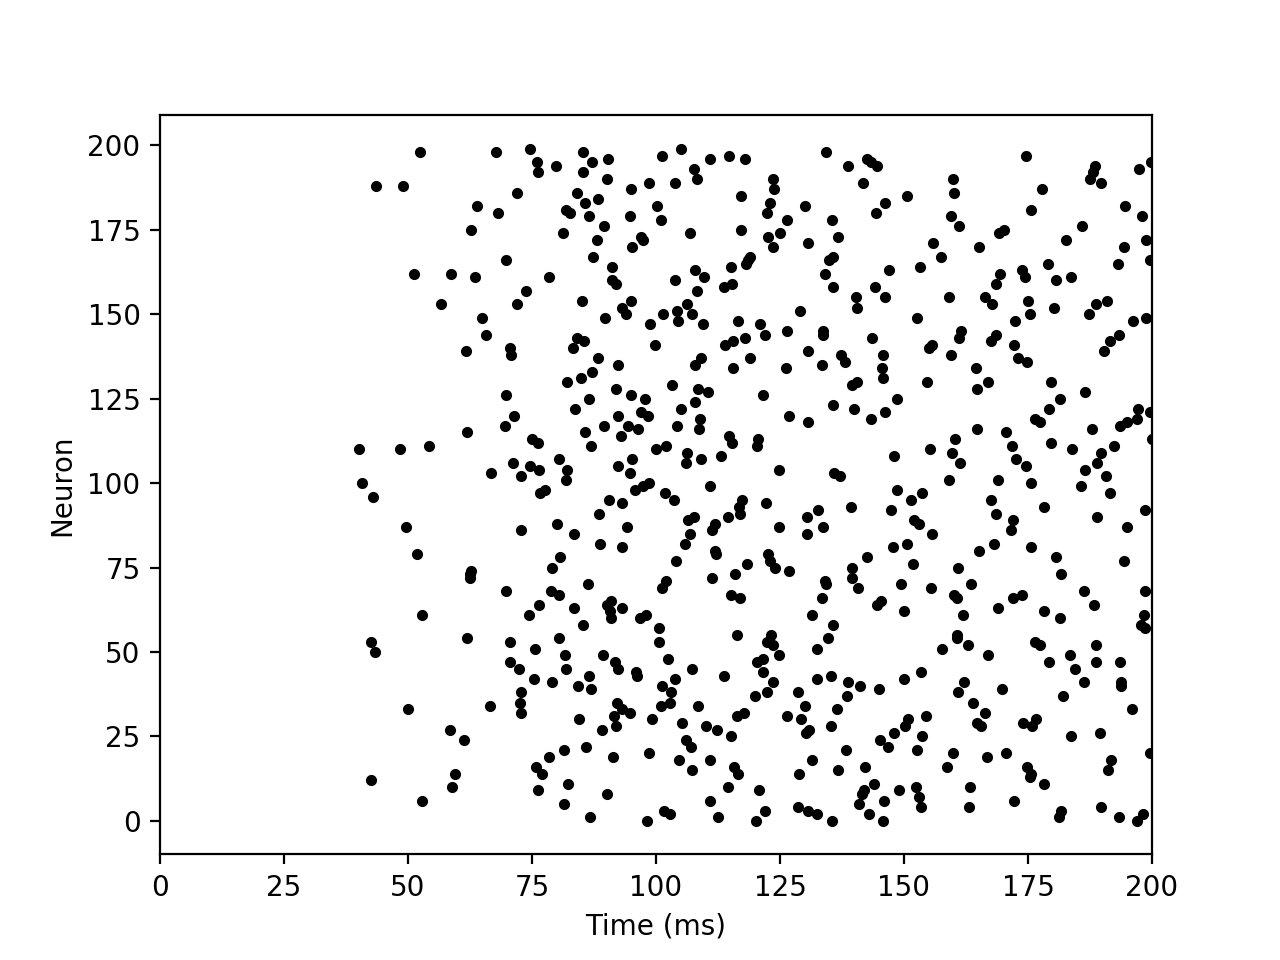

[Text(0,0.5,'Neuron'), Text(0.5,0,'Time (ms)')]

In [13]:
%matplotlib nbagg
fig, ax = plt.subplots()
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlim=[0, h.tstop])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

In [9]:
Neach_side = 100
Linput = []
Rinput = []

for i in range(Neach_side):
    ic = h.NetStimFD()
    ic.interval = 20
    ic.noise = 1
    ic.start = 500
    ic.duration = 50
    ic.seed(i+3333)
    Linput.append(ic)

    ic = h.NetStimFD()
    ic.interval = 20
    ic.noise = 1
    ic.start = 50
    ic.duration = 1000
    ic.seed(i+4333)
    Rinput.append(ic)

nc_inputs = []
for i in range(Ncells):
    if i<(Nexc/2):
        bias = 0.1
    else:
        bias = -0.1
        
    for j in range(Neach_side):
        if np.random.rand()<0.2+bias:
            nc = h.NetCon(Linput[j], pnm.gid2cell[i].synlist[0])
            nc.weight[0] = 1e-2
            nc_inputs.append(nc)

        if np.random.rand()<0.2-bias:
            nc = h.NetCon(Rinput[j], pnm.gid2cell[i].synlist[0])
            nc.weight[0] = 1e-2
            nc_inputs.append(nc)


<IPython.core.display.Javascript object>


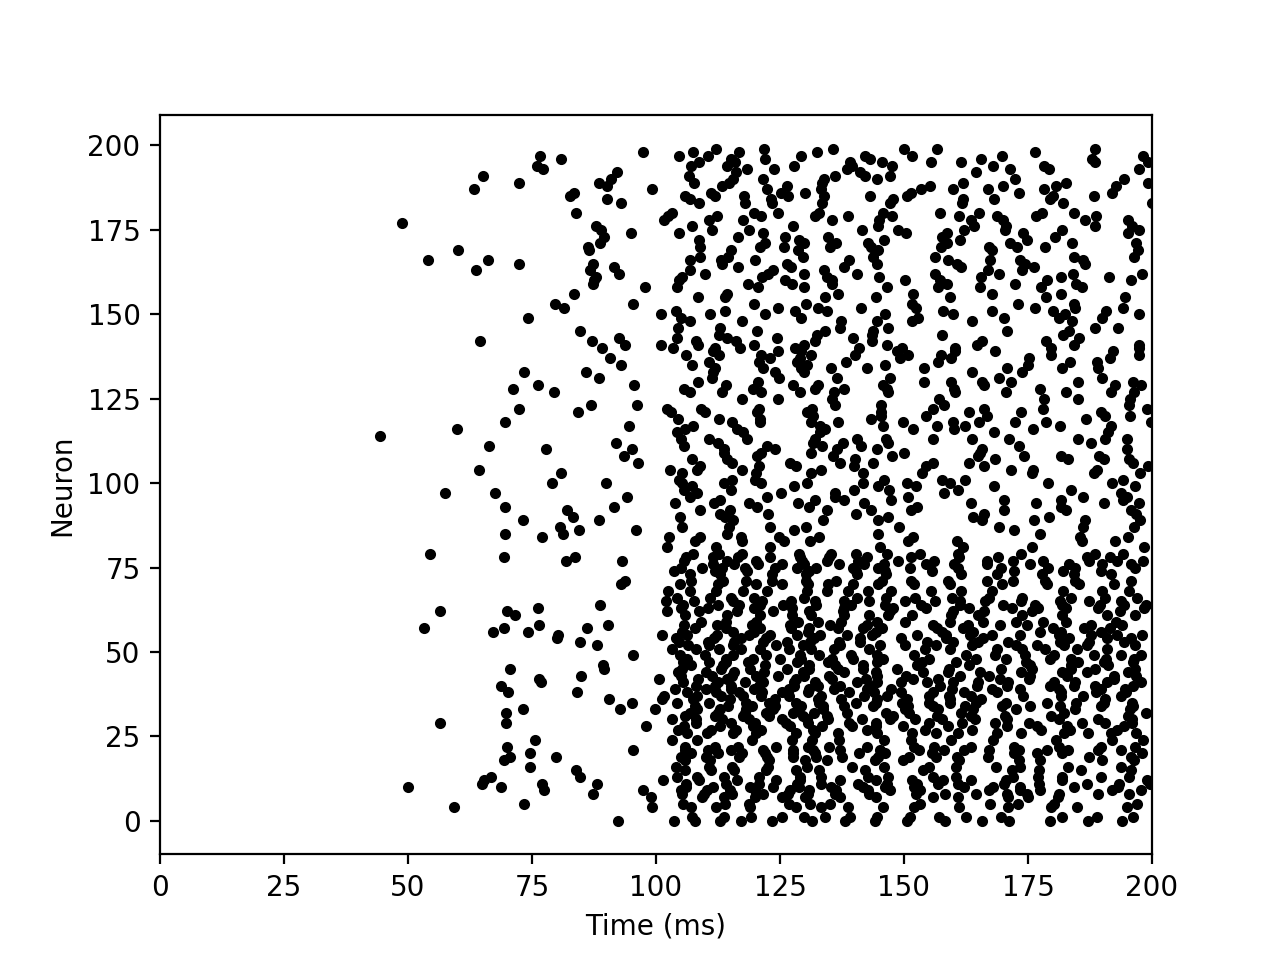

[Text(0,0.5,'Neuron'), Text(0.5,0,'Time (ms)')]

In [10]:
for x in Linput:
    x.start = 100

h.tstop = 200
h.init()
pnm.run()

%matplotlib nbagg
fig, ax = plt.subplots()
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlim=[0, h.tstop])
ax.set(xlabel='Time (ms)', ylabel='Neuron')